In [ ]:
pip install python-binance
pip install keras_tuner

     |████████████████████████████████| 63 kB 2.4 MB/s 
     |████████████████████████████████| 1.1 MB 24.1 MB/s 
     |████████████████████████████████| 103 kB 47.0 MB/s 
     |████████████████████████████████| 216 kB 53.0 MB/s 
     |████████████████████████████████| 288 kB 49.1 MB/s 
     |████████████████████████████████| 192 kB 44.4 MB/s 
     |████████████████████████████████| 271 kB 45.6 MB/s 
     |████████████████████████████████| 160 kB 51.6 MB/s 


In [ ]:
import pandas as pd
import time
from binance import Client, ThreadedWebsocketManager
from datetime import datetime
import numpy as np
from keras.models import Sequential, Model
from keras_tuner import BayesianOptimization
from keras.layers import Dense, Activation, Dropout, LSTM, BatchNormalization, GRU, Input
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import mean_absolute_error
from termcolor import colored as cl 
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from google.colab import drive 
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, auc, roc_curve
import warnings
warnings.filterwarnings("ignore")

# Request Data

In [ ]:
api_key = api_key
api_secret = api_secret
client = Client(api_key, api_secret)
target_col = 'Close'

In [ ]:
def get_klines_iter(symbol, interval, start, end, limit=1000):
    df = pd.DataFrame()
    bars = client.get_historical_klines(symbol,interval,start,end,limit)
    columns = ["time", "Open", "High", "Low", "Close", "Volume",\
               "Close_time", "Quote_Asset_Volume", "Num_Trades", "Taker buy base asset volume",\
               "Taker buy quote asset volume", "Ignore"]
    df = pd.DataFrame(bars, columns=columns) 
    df = df.astype('float32')
    df['ticker']= symbol
    return df

In [ ]:
def get_data(start_date = '1 Jan,2020', end_data = '26 Nov,2021', interval = '1d'):
    BTC = get_klines_iter('BTCUSDT', interval, start_date, end_data).loc[:,['ticker', "Open", "High", "Low", "Close", "time",  "Volume",\
                                                                            "Quote_Asset_Volume", \
                                                                            "Num_Trades", \
                                                                             "Taker buy base asset volume",\
                                                                              "Taker buy quote asset volume"]]
    BTC['time'] = pd.to_datetime(BTC['time'], unit = 'ms')
    BTC = BTC.set_index('time')

    ETH = get_klines_iter('ETHUSDT', interval, start_date, end_data).loc[:,['ticker', "Open", "High", "Low", "Close", "time",  "Volume",\
                                                                            "Quote_Asset_Volume", \
                                                                            "Num_Trades", \
                                                                             "Taker buy base asset volume",\
                                                                              "Taker buy quote asset volume"]]
    ETH['time'] = pd.to_datetime(ETH['time'], unit = 'ms')
    ETH = ETH.set_index('time')
    
    ADA = get_klines_iter('ADAUSDT', interval, start_date, end_data).loc[:,['ticker', "Open", "High", "Low", "Close", "time",  "Volume",\
                                                                            "Quote_Asset_Volume", \
                                                                            "Num_Trades", \
                                                                             "Taker buy base asset volume",\
                                                                              "Taker buy quote asset volume"]]
    ADA['time'] = pd.to_datetime(ADA['time'], unit = 'ms')
    ADA = ADA.set_index('time')

    BNB = get_klines_iter('BNBUSDT', interval, start_date, end_data).loc[:,['ticker', "Open", "High", "Low", "Close", "time",  "Volume",\
                                                                            "Quote_Asset_Volume", \
                                                                            "Num_Trades", \
                                                                             "Taker buy base asset volume",\
                                                                              "Taker buy quote asset volume"]]
    BNB['time'] = pd.to_datetime(BNB['time'], unit = 'ms')
    BNB = BNB.set_index('time')

    LTC = get_klines_iter('LTCUSDT', interval, start_date, end_data).loc[:,['ticker', "Open", "High", "Low", "Close", "time",  "Volume",\
                                                                            "Quote_Asset_Volume", \
                                                                            "Num_Trades", \
                                                                             "Taker buy base asset volume",\
                                                                              "Taker buy quote asset volume"]]
    LTC['time'] = pd.to_datetime(LTC['time'], unit = 'ms')
    LTC = LTC.set_index('time')


    return BTC, ETH, ADA, BNB, LTC

In [ ]:
def line_plot(line1, line2, line3, label1=None, label2=None, label3=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.plot(line3, label=label3, linewidth=lw)
    ax.set_ylabel('price', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

line_plot(train[target_col], val[target_col], test[target_col], 'training', 'val', 'test', title='')

# Model Construction

Data Preprocessing

In [ ]:
BTC, ETH, ADA, BNB, LTC = get_data()

In [ ]:
def prepare_data(data, split = 0.1, look_back=25, lead_time=1):

    X_train, y_train = [], []
    X_test, y_test = [], []

    scaler = MinMaxScaler(feature_range=(0, 1))
    data = data.drop(['ticker'], axis=1)
    data_norm = pd.DataFrame(scaler.fit_transform(data))

    train, test= np.split(data_norm, [int(split *len(data_norm))])

    for i in range(len(train)-look_back-lead_time):
        a = train.iloc[i:(i+look_back), :]
        a = np.array(a)
        X_train.append(a)
        
    for i in range(len(test)-look_back-lead_time):
        a = test.iloc[i:(i+look_back), :]
        a = np.array(a)
        X_test.append(a)


    y_train = train.iloc[:,3][(look_back+lead_time):].values
    y_train_lag = train.iloc[:,3][(look_back):-lead_time].values
    y_train = pd.DataFrame(y_train > y_train_lag).astype(int)

    y_test = test.iloc[:,3][(look_back+lead_time):].values
    y_test_lag = test.iloc[:,3][(look_back):-lead_time].values
    y_test = pd.DataFrame(y_test > y_test_lag).astype(int)

    y_train_raw, y_test_raw = np.split(data.iloc[:,3], [int(split *len(data))])
        
    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), y_test_raw

In [ ]:
BTC_train, Price_BTC_train, BTC_test, Price_BTC_test, Price_BTC_test_raw = prepare_data(BTC)
ETH_train, Price_ETH_train, ETH_test, Price_ETH_test, Price_ETH_test_raw = prepare_data(ETH)
ADA_train, Price_ADA_train, ADA_test, Price_ADA_test, Price_ADA_test_raw = prepare_data(ADA)
BNB_train, Price_BNB_train, BNB_test, Price_BNB_test, Price_BNB_test_raw = prepare_data(BNB)
LTC_train, Price_LTC_train, LTC_test, Price_LTC_test, Price_LTC_test_raw = prepare_data(LTC)

Model Construction

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
def build_LSTM_model(hp):
    
    model_BTC_in = Input(shape=(n_input_1, n_input_2))

    model_BTC_out = LSTM(units=hp.Int('neurons_BTC',min_value=128,
                                        max_value=128), 
                                activation='tanh', 
                                input_shape=(n_input_1, n_input_2),
                                recurrent_dropout=0.0)(model_BTC_in)

    model_BTC = Model(model_BTC_in, model_BTC_out)

    model_ETH_in = Input(shape=(n_input_1, n_input_2))

    model_ETH_out = LSTM(units=hp.Int('neurons_ETH',min_value=32,
                                        max_value=128,
                                        step=32), 
                                activation='tanh', 
                                input_shape=(n_input_1, n_input_2),
                                recurrent_dropout=0.0)(model_ETH_in)

    model_ETH = Model(model_ETH_in, model_ETH_out)

    model_ADA_in = Input(shape=(n_input_1, n_input_2))

    model_ADA_out = LSTM(units=hp.Int('neurons_ADA',min_value=32,
                                        max_value=128,
                                        step=32), 
                                activation='tanh', 
                                input_shape=(n_input_1, n_input_2),
                                recurrent_dropout=0.0)(model_ADA_in)

    model_ADA = Model(model_ADA_in, model_ADA_out)

    model_BNB_in = Input(shape=(n_input_1, n_input_2))

    model_BNB_out = LSTM(units=hp.Int('neurons_BNB',min_value=32,
                                        max_value=128,
                                        step=32), 
                                activation='tanh', 
                                input_shape=(n_input_1, n_input_2),
                                recurrent_dropout=0.0)(model_BNB_in)

    model_BNB = Model(model_BNB_in, model_BNB_out)

    model_LTC_in = Input(shape=(n_input_1, n_input_2))

    model_LTC_out = LSTM(units=hp.Int('neurons_LTC',min_value=32,
                                        max_value=128,
                                        step=32), 
                                activation='tanh', 
                                input_shape=(n_input_1, n_input_2),
                                recurrent_dropout=0.0)(model_LTC_in)

    model_LTC = Model(model_LTC_in, model_LTC_out)

    mesh = concatenate([model_ETH_out, model_ADA_out, model_BNB_out, model_LTC_out])
    external_out = Dense(32, activation='tanh')(mesh)

    concatenated = concatenate([model_BTC_out, external_out])
    out = Dense(1, activation='sigmoid', name='output_layer')(concatenated)

    merged_model = Model([model_BTC_in, model_ETH_in, model_ADA_in, model_BNB_in, model_LTC_in], out)
    merged_model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=RMSprop(hp.Choice('learning_rate',
                                                                                                    values=[1e-2, 1e-3, 1e-4])))
  
    
    return merged_model

In [ ]:
n_input_1 = BTC_train.shape[1]
n_input_2 = BTC_train.shape[2]

bayesian_opt_tuner = BayesianOptimization(
    build_LSTM_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='drive/My Drive/MSBA Team 13/Managing Big Data/Project',
    project_name='LSTM_Bayesian_OPT',
    overwrite=True)

In [ ]:
bayesian_opt_tuner.search([BTC_train, ETH_train, ADA_train, BNB_train, LTC_train], Price_BTC_train, epochs=5, batch_size=16,
     validation_split=0.2, shuffle=False, verbose=1)

Trial 10 Complete [00h 00m 15s]
val_accuracy: 0.5555555820465088

Best val_accuracy So Far: 0.5555555820465088
Total elapsed time: 00h 02m 24s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hyperparameters = bayesian_opt_tuner.get_best_hyperparameters(1)[0]
print(best_hyperparameters.values)

{'neurons_BTC': 128, 'neurons_ETH': 96, 'neurons_ADA': 64, 'neurons_BNB': 128, 'neurons_LTC': 64, 'learning_rate': 0.01}


In [ ]:
model = bayesian_opt_tuner.hypermodel.build(best_hyperparameters)
history = model.fit([BTC_train, ETH_train, ADA_train, BNB_train, LTC_train], Price_BTC_train, epochs=50,
     validation_split=0.2, shuffle=False, verbose=1, callbacks=[es])

Epoch 1/50
2/2 [==============================] - 11s 3s/step - loss: 0.9582 - accuracy: 0.3824 - val_loss: 0.6915 - val_accuracy: 0.5556
Epoch 2/50
2/2 [==============================] - 0s 79ms/step - loss: 0.8460 - accuracy: 0.4118 - val_loss: 0.7575 - val_accuracy: 0.5556
Epoch 3/50
2/2 [==============================] - 0s 92ms/step - loss: 0.8742 - accuracy: 0.4118 - val_loss: 0.7515 - val_accuracy: 0.5556
Epoch 4/50
2/2 [==============================] - 0s 97ms/step - loss: 0.8364 - accuracy: 0.4706 - val_loss: 0.7645 - val_accuracy: 0.5556
Epoch 5/50
2/2 [==============================] - 0s 89ms/step - loss: 0.8558 - accuracy: 0.4706 - val_loss: 0.7725 - val_accuracy: 0.5556
Epoch 6/50
2/2 [==============================] - 0s 88ms/step - loss: 0.8672 - accuracy: 0.4706 - val_loss: 0.7774 - val_accuracy: 0.5556
Epoch 7/50
2/2 [==============================] - 0s 88ms/step - loss: 0.8741 - accuracy: 0.4706 - val_loss: 0.7804 - val_accuracy: 0.5556
Epoch 8/50
2/2 [============

In [ ]:
pred = model.predict([BTC_test, ETH_test, ADA_test, BNB_test, LTC_test])

# Model Evaluation

In [ ]:
def plot_ROC_curve(label, clr, ls, y_pred, y_test):

    fpr, tpr, thresholds = roc_curve(y_true=y_test, # Build ROC curve
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)                # Compute Area Under the Curve (AUC) 
    plt.plot(fpr, tpr,                         # Plot ROC Curve and create label with AUC values
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))
    return plt

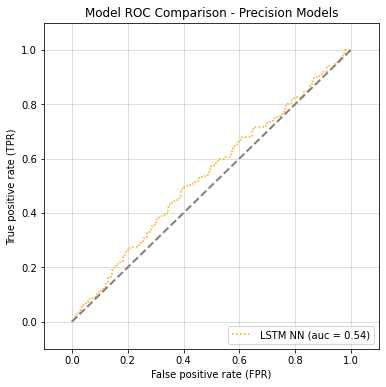

In [ ]:
plt.figure(figsize=(6,6)) 

plot_ROC_curve(label='LSTM NN', clr='orange', ls=':', y_pred=pred, y_test=Price_BTC_test)

plt.plot([0, 1], [0, 1], # Visualize random classifier
         linestyle='--',
         color='gray',
         linewidth=2)

plt.legend(loc='lower right')
plt.xlim([-0.1, 1.1])   #limits for x axis
plt.ylim([-0.1, 1.1])   #limits for y axis
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.title('Model ROC Comparison - Precision Models')

plt.show()

# Implementing One-day Buy and Sell Strategy

In [ ]:
def ls_strategy(data, price, threshold = 0.5):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_norm = scaler.fit_transform(data)

    buy_price = []
    sell_price = []
    transaction_buy = []
    transaction_sell = []
    price = price.iloc[25:-1]
    
    sell_price.append(np.nan)
    
    for i in range(len(data_norm)-1):
        if data_norm[i] > threshold:
            buy_price.append(price[i])
            sell_price.append(price[i+1])
            transaction_buy.append(price[i])
            transaction_sell.append(price[i+1])
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            transaction_buy.append(1)
            transaction_sell.append(1/0.999)
    
    buy_price.append(np.nan)
    
    return buy_price, sell_price, transaction_buy, transaction_sell

In [ ]:
def plot_ls(pred, price):
    preds_pct = pd.Series(index=Price_BTC_test_raw.iloc[25:-1].index, data=pred.squeeze())
    fig,ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(price, linestyle = '--', color = 'orange')
    ax.scatter(preds_pct.index, buy_price, marker = '^', color = 'green', label = 'BUY', s = 30)
    ax.scatter(preds_pct.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 30)
    plt.title('One-day Buy and Sell Strategy')
    plt.legend(loc='best')
    plt.show()

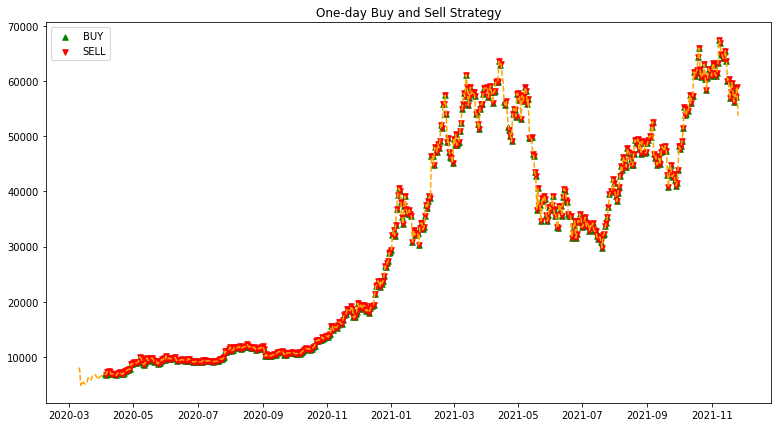

In [ ]:
buy_price, sell_price, buy, sell = ls_strategy(pred, Price_BTC_test_raw, threshold = 0.05)
plot_ls(pred, Price_BTC_test_raw)

# Backtesting

In [ ]:
def portfolio(buy, sell, test_price, plot = 1):
    value = 100000
    value_2 = 100000
    portfolio_1 = []
    portfolio_2 = []
    for i in range(25):
      portfolio_1.append(1)
    portfolio_2.append(1)
    for i in range(len(buy)):
        value = value/buy[i]*sell[i] * 0.999
        portfolio_1.append(value/100000)
    for i in range(len(test_price)-1):
        value_2 = value_2/test_price[i]*test_price[i+1] * 0.999
        portfolio_2.append(value_2/100000)
    print('Profit gained from the LSTM One-day Buy and Sell Strategy by investing $100k in BTC: {}'.format(value))
    print('Profit gained from Benchmark Buy and Sell strategy by investing $100k in BTC: {}'.format(value_2))
    portfolio_1 = pd.Series(index=Price_BTC_test_raw.index[1:-1], data=portfolio_1)
    portfolio_2 = pd.Series(index=Price_BTC_test_raw.index, data=portfolio_2)
    fig,ax = plt.subplots(1, figsize=(13, 7), sharex='col', sharey='col')
    ax.plot(portfolio_1, label = 'LSTM One-day Buy and Sell', color = 'orange')
    plt.legend(loc='upper left')
    ax2=ax.twinx()
    ax2.plot(portfolio_2, label = 'Benchmark Buy and Sell')
    ax.set_ylim([0, 8])
    ax2.set_ylim([0, 8])
    plt.title('One-day Buy and Sell Strategy with 0.1% Transaction Fee')
    plt.legend(loc='upper right')
    plt.show()

Profit gained from the LSTM One-day Buy and Sell Strategy by investing $100k in BTC: 582158.4200103726
Profit gained from Benchmark Buy and Sell strategy by investing $100k in BTC: 363794.8096045189


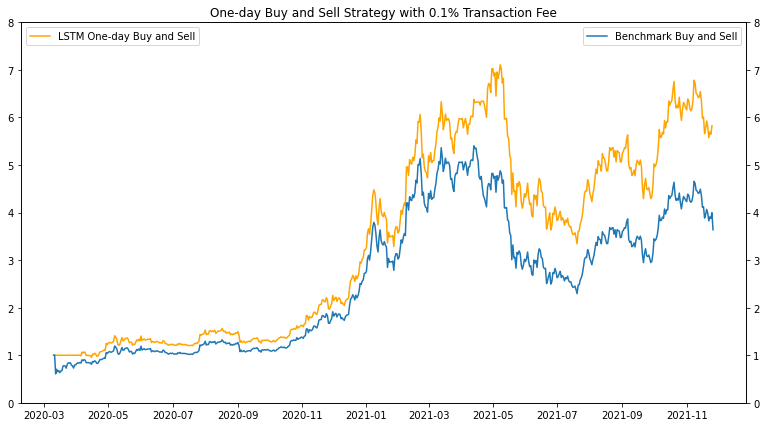

In [ ]:
portfolio(buy, sell, Price_BTC_test_raw)